In [1]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoProcessor
from datasets import load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import json
import os
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
# 设置设备：如果有 GPU 就用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 加载模型到 GPU
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map=device
)
# 加载处理器
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
with open("split_result/test_zeroshot.jsonl", 'r') as fr:
  arxiv_qa = [ json.loads(line.strip()) for line in fr]
  
test_dataset = []
for i in range(len(arxiv_qa)):
    sample = arxiv_qa[i]
    try:
        if sample['question'] is None:
            print(f"第 {i} 个样本没有问题，跳过")
            continue

        test_dataset.append({
            'id':sample['id'],
            "image": sample['image'], 
            "question": sample["question"],
            "choices": sample["options"],
            "answer": sample["label"],
            "solution": sample["rationale"]
        })
    except Exception as e:
        print(f"跳过第 {i} 个样本，错误：{e}")
        continue

In [4]:
def build_message(sample):
    content = []
    if sample['image'] is not None:
        content.append({"type": "image", "image": "/root/IC_MLLM_VQA/ArxivQA/pure_testing/"+sample['image']}) #绝对路径
    
    question_text = f"Question: {sample['question']}\nChoices:\n"
    for idx, choice in enumerate(sample['choices']):
        question_text += f"{chr(65 + idx)}. {choice}\n"
    
    question_text += "Read the image carfelly and please select the correct answer and explain why."
    content.append({"type": "text", "text": question_text})
    
    return [{"role": "user", "content": content}]

In [5]:
test_dataset[159]

{'id': 'cs-8945',
 'image': 'images/2306.03570_3.jpg',
 'question': 'What do the blurred images in section b) of the figure represent?',
 'choices': ['A) Random noise patterns.',
  'B) Pixelated versions of the original images.',
  "C) Reconstructed images based on an algorithm's understanding of the original images.",
  'D) Completely new images generated without reference to the originals.'],
 'answer': 'C',
 'solution': "The blurred images in section b) labeled as 'Manifolds of reconstructions' suggest that these are the outputs of a computational process attempting to reconstruct or approximate the original images. They are not random, pixelated, or completely new but are algorithmically derived from the original images."}

[{'role': 'user', 'content': [{'type': 'image', 'image': '/root/IC_MLLM_VQA/ArxivQA/pure_testing/images/1705.01759_4.jpg'}, {'type': 'text', 'text': 'Question: Based on the figures provided, what can be inferred about the environmental conditions under which the "Our" system performs subject tracking?\nChoices:\nA. A) It performs optimally in indoor environments only.\nB. B) It is unaffected by outdoor lighting conditions.\nC. C) It requires clear weather conditions to track effectively.\nD. D) It performs consistently in various settings, both indoor and outdoor.\nRead the image carfelly and please select the correct answer and explain why.'}]}]


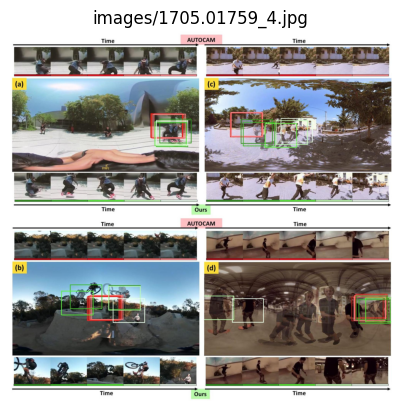

In [6]:
sample = test_dataset[0]
messages = build_message(sample)
image_path = '/root/IC_MLLM_VQA/ArxivQA/pure_testing/'+sample["image"]
image_inputs = Image.open(image_path).convert("RGB")
print (messages)
plt.imshow(image_inputs)
plt.axis("off")
plt.title(sample["image"])
plt.show()

In [9]:
# 映射选项
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
answer_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3,'E': 4}

# 提取选项字母的函数（支持 C、c、C.、C) 等）
def extract_choice_letter(ans):
    if not isinstance(ans, str):
        return None
    ans = ans.strip()
    match = re.match(r"([A-Da-d])[\.\)]?", ans)
    return match.group(1).upper() if match else None

# 构建模型输入消息
def build_message(sample):
    content = []
    if sample['image'] is not None:
        content.append({"type": "image", "image": sample['image']})
    question_text = f"Question: {sample['question']}\nChoices:\n"
    for idx, choice in enumerate(sample['choices']):
        question_text += f"{chr(65 + idx)}. {choice}\n"
    question_text += "Please select the correct answer and explain why."
    content.append({"type": "text", "text": question_text})
    return [{"role": "user", "content": content}]

# 解析模型输出（返回编号+解释）
def parse_output(output):
    output = output.strip()
    answer_match = re.search(r"\b([A-Da-d])[\.\:\)]?", output)
    answer_letter = answer_match.group(1).upper() if answer_match else None
    answer = answer_mapping.get(answer_letter, -1)
    explanation = ""
    if answer != -1:
        idx = output.find(answer_match.group(0))
        if idx != -1:
            explanation = output[idx + len(answer_match.group(0)):].strip()
    return answer, explanation

# 初始化评估工具
rouge = Rouge()
smoothie = SmoothingFunction().method1
vectorizer = CountVectorizer(stop_words="english").fit([s["solution"] for s in test_dataset])
keywords = set(vectorizer.get_feature_names_out())

# 记录结果
all_records = []
# subset = test_dataset[0:2]
for idx, sample in enumerate(tqdm(test_dataset, desc="Evaluating", ncols=100, leave=False)):
    # 构建输入
    messages = build_message(sample)
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_path = '/root/IC_MLLM_VQA/ArxivQA/pure_testing/'+sample["image"]
    image_inputs = Image.open(image_path).convert("RGB").resize((224, 224))

    inputs = processor(text=[text], images=image_inputs, return_tensors="pt", padding=True).to(device)
    try:
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                if torch.isnan(v).any() or torch.isinf(v).any():
                    raise ValueError("⚠️ 发现 NAN/INF 值，跳过样本")

        generated_ids = model.generate(**inputs, max_new_tokens=128)
    except Exception as e:
        print(f"❌ 崩溃样本: {sample['image']} -> {e}")
        continue
    
    output = processor.batch_decode(generated_ids[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True)[0]

    # 解析模型输出
    pred_answer_id, pred_explanation = parse_output(output)

    # 计算 BLEU
    if pred_explanation:
        bleu = sentence_bleu([sample["solution"].split()], pred_explanation.split(), smoothing_function=smoothie)
    else:
        bleu = 0.0

    # 计算 ROUGE-L
    try:
        rouge_score = rouge.get_scores(pred_explanation, sample["solution"])[0]["rouge-l"]["f"]
    except:
        rouge_score = 0.0

    # 计算关键词重叠
    gt_tokens = set(sample["solution"].lower().split())
    pred_tokens = set(pred_explanation.lower().split())
    overlap = len(gt_tokens & pred_tokens & keywords)
    keyword_score = overlap / max(len(gt_tokens & keywords), 1)

    # 提取真实答案
    true_letter = extract_choice_letter(sample["answer"])
    true_answer_id = answer_mapping.get(true_letter, -1)

    # 存入结果
    all_records.append({
        "Question": sample["question"],
        "Choices": "\n".join(sample["choices"]),
        "True Answer": sample["answer"],
        "True Answer ID": true_answer_id,
        "Predicted Answer ID": pred_answer_id,
        "Correct": int(true_answer_id == pred_answer_id),
        "Model Output": output,
        "Model Explanation": pred_explanation,
        "Reference Solution": sample["solution"],
        "BLEU": bleu,
        "ROUGE-L": rouge_score,
        "Keyword Overlap": keyword_score
    })

# 构建结果表格
results_df = pd.DataFrame(all_records)
results_df.to_csv("Qwen3B_ArxivQA_testing_physics.csv", index=False, encoding="utf-8-sig")

# 汇总指标（基于编号比较准确率）
acc = accuracy_score(results_df["True Answer ID"], results_df["Predicted Answer ID"])
f1 = f1_score(results_df["True Answer ID"], results_df["Predicted Answer ID"], average='macro')
avg_bleu = results_df["BLEU"].mean()
avg_rouge = results_df["ROUGE-L"].mean()
avg_keyword_overlap = results_df["Keyword Overlap"].mean()

# 打印汇总结果
print("\n📊 Summary Metrics:")
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Avg BLEU: {avg_bleu:.4f}")
print(f"✅ Avg ROUGE-L: {avg_rouge:.4f}")
print(f"✅ Avg Keyword Overlap: {avg_keyword_overlap:.4f}")
print("\n📁 结果已保存为 Qwen3B_ArxivQA_testing_physics.csv（UTF-8 with BOM）")



Evaluating:   0%|                                                           | 0/300 [00:00<?, ?it/s]


📊 Summary Metrics:
✅ Accuracy: 0.3033
✅ F1 Score: 0.2294
✅ Avg BLEU: 0.0739
✅ Avg ROUGE-L: 0.3112
✅ Avg Keyword Overlap: 0.3988

📁 结果已保存为 Qwen3B_ArxivQA_testing_physics.csv（UTF-8 with BOM）
